In [1]:
#!pip install yahoo_fin
#!pip install yahoo_fin --upgrade
#!pip install requests_html
#!pip install investpy

In [2]:
import pandas as pd
import assets_data as assets
import warnings
warnings.filterwarnings("ignore")
from backtest_historical import *
from portfolio_construction import *
from metrics import *
from backtest_simulation import *
from charting import *

In [3]:
######### Load Historical Data ########

In [4]:
data = assets.historical_data()
stock_rets = data.stock_return()
sp500_rets = data.spy_rets()

In [5]:
######### Backtest for historical data ########

In [6]:
# Build risky account: Risk Parity Portfolio
portfolio_r = portfolio_risky_account(estimation_window=60)
risky_account = portfolio_r.risk_parity_portfolio(r = stock_rets)[0]

# Build a Portfolio based on CPPI
run_cppi = cppi()
risky_r = risky_account
safe_r = None
m=6
cash=1000
floor=0.8
drawdown= 0.2
riskfree_rate=0.025

result_cppi = run_cppi.cppi_construction(risky_r, safe_r, m, cash, floor, drawdown, riskfree_rate)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Sharpe Ratio,Max Drawdown
CPPI,0.110876,0.160912,-0.180930,3.996681,0.016491,0.520708,-0.189651
Non-CPPI,0.098211,0.256529,-0.162377,3.435540,0.026635,0.278444,-0.320881
SP500,0.038523,0.184661,-0.382117,4.078038,0.019866,0.071441,-0.234138


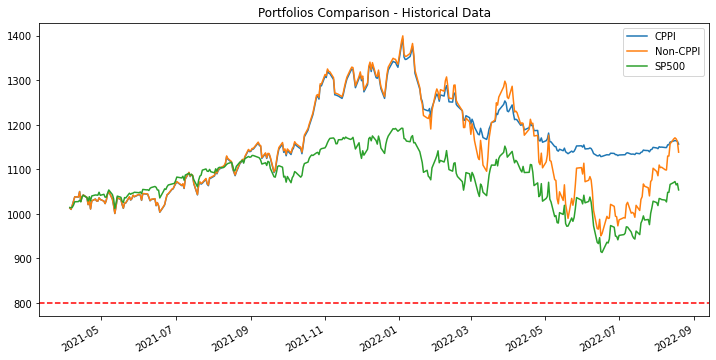

In [7]:
floor_value = cash * floor
cppi_rets = result_cppi['Wealth'].pct_change().dropna()['Wealth History']
non_cppi_rets = result_cppi['Risky Wealth'].pct_change().dropna()['Risky Account']
sp500_rets_ = sp500_rets['SP500'].loc[non_cppi_rets.index]
btr= pd.DataFrame({"CPPI": cppi_rets, "Non-CPPI": non_cppi_rets, "SP500": sp500_rets_})

value_growth = cash*(1+btr).cumprod()
ax = value_growth.plot(figsize=(12,6), title="Portfolios Comparison - Historical Data")
ax.axhline(y=floor_value, color='r',linestyle='--')

stats = summary_stats(periods_per_year=252, riskfree_rate=riskfree_rate)
stats.summary(btr)

In [8]:
###########################################################################
# simulation and backtest
###########################################################################

In [9]:
# stocks
simulaton = monte_carlo(n_scenarios = 5, n_years = 8, steps_per_year = 252)
rets_stocks_simu = simulaton.equity_return(mu=0.08, sigma=0.15, s_0=100.0)
stock_price, stocks_rets = rets_stocks_simu
stocks_rets = stocks_rets[1:]

# bonds
int_rate_simu = simulaton.cir(a=0.05, b=0.03, sigma=0.05, r_0=.025)[0]
bond_price = simulaton.bond_price(maturity=10, principal=100, coupon_rate=0.0303, coupons_per_year=2, discount_rate=int_rate_simu)
bond_rets = bond_price.pct_change()[1:]

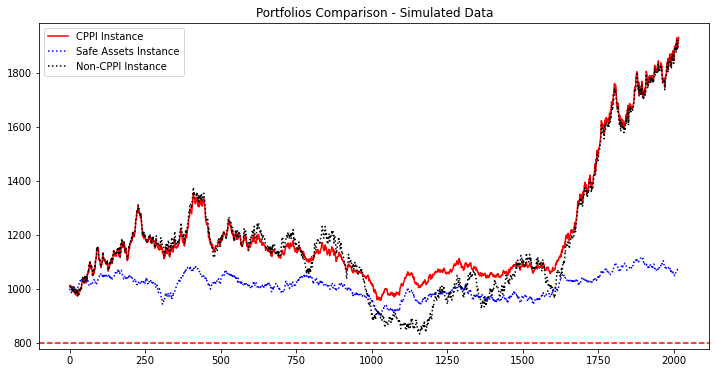

In [15]:
run_cppi = cppi()
risky_r = stocks_rets
safe_r = bond_rets
m=5
cash=1000
floor=0.8
drawdown= 0.25
riskfree_rate=0.025

result_cppi = run_cppi.cppi_construction(risky_r, safe_r, m, cash, floor, drawdown,  riskfree_rate)
floor_value = cash * floor

ax = result_cppi['Wealth'][4].rename('CPPI Instance').plot(figsize=(12,6),  style='r-',legend=True, title="Portfolios Comparison - Simulated Data")
safe = cash*(result_cppi['safe_r']+1).cumprod()[4]
safe.rename('Safe Assets Instance').plot(ax=ax, color='b',linestyle=':', legend=True)
result_cppi['Risky Wealth'][4].rename('Non-CPPI Instance').plot(ax=ax, style='k:', legend=True)
ax.axhline(y=floor_value, color='r',linestyle='--')

,CPPI Performance Average: Simulated Data
Annualized Return,0.056221
Annualized Vol,0.109553
Skewness,-0.008113
Kurtosis,3.250851
Cornish-Fisher VaR (5%),0.011093
Sharpe Ratio,0.189149
Max Drawdown,-0.186654


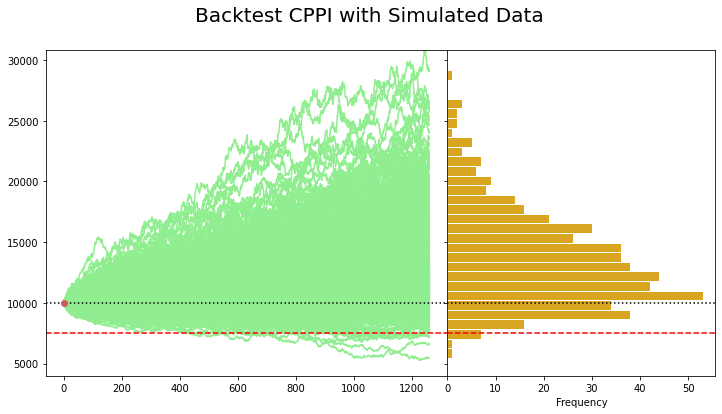

In [11]:
visual = visualisation(n_scenarios=500,
                        steps_per_year=252,
                        n_years=5,
                        mu=0.09,
                        sigma_stocks=.15,
                        a=.05,
                        b=.03,
                        sigma_bonds=.05,
                        r_0=.025,
                        m=3,
                        cash=10000,
                        floor=0.75,
                        drawdown = 0.3)
visual.charting_display()